In [141]:
import pandas as pd
import jax
import jax.numpy as jnp
import numpy as np
import os
import sys 
import math

import importlib

from pypomp.fit import fit
from pypomp.pomp_class import Pomp

import matplotlib.pyplot as plt

from scipy import stats
from jax.scipy.stats import nbinom
from scipy.stats import ttest_ind

sys.path.insert(0, 'pypomp')
from dacca import dacca, dacca_internal
from LG import LG, LG_internal
from simulate import simulate

Daphnia Model:

In [143]:
mesocosm_data = pd.read_excel("./pypomp/data/Mesocosmdata.xls", sheet_name=0)

key = jax.random.PRNGKey(2468)  

dentNoPara = mesocosm_data.iloc[:100][['rep', 'day', 'dent.adult']]

dentNoPara['day'] = (dentNoPara['day'] - 1) * 5 + 7

dentNoPara = dentNoPara.iloc[::-1].reset_index(drop=True)

data = []
dentadult = []
trails = ["A", "B", "C", "D", "E", "F", "G", "H", "I", "J"]

for trail in trails:
    subset_data = dentNoPara[dentNoPara['rep'] == trail][['day', 'dent.adult']]
    subset_dentadult = dentNoPara[dentNoPara['rep'] == trail][['dent.adult']]
    data.append(subset_data)
    dentadult.append(subset_dentadult)

def transform_thetas(sigSn, sigF, f_Sn, rn, k_Sn, sigJn, theta_Sn, theta_Jn, lambda_Jn):
    return jnp.array([jnp.log(sigSn), jnp.log(sigF), jnp.log(f_Sn), jnp.log(rn), jnp.log(k_Sn), jnp.log(sigJn), jnp.log(theta_Sn), jnp.log(theta_Jn), jnp.log(lambda_Jn)])

def get_thetas(thetas):
    sigSn = jnp.exp(thetas[0])
    sigF = jnp.exp(thetas[1])
    f_Sn = jnp.exp(thetas[2])
    rn = jnp.exp(thetas[3])
    k_Sn = jnp.exp(thetas[4])
    sigJn = jnp.exp(thetas[5])
    theta_Sn = jnp.exp(thetas[6])
    theta_Jn = jnp.exp(thetas[7])
    lambda_Jn = jnp.exp(thetas[8])

    return sigSn, sigF, f_Sn, rn, k_Sn, sigJn, theta_Sn, theta_Jn, lambda_Jn

#state : "Sn","Jn" ,"error_count", "F", "T_Sn", "day_index"
#thetas :  sigSn, sigF, f_Sn, rn, k_Sn, sigJn, theta_Sn, theta_Jn, lambda_Jn

def rproc_loop_noi_rm(state, thetas, key, num_steps):
    # extract states and thetas
    Sn, Jn, F, T_Sn, error_count = state[0], state[1], state[2], state[3], state[4]
    sigSn, sigF, f_Sn, rn, k_Sn, sigJn, theta_Sn, theta_Jn, lambda_Jn = get_thetas(thetas)

    # contant
    delta = 0.013
    dt = 0.25
    
    def loop_body(i, loop_state):
        Sn, Jn, F, T_Sn, error_count, key = loop_state
        # progressing the states and updating them
        Sn_term = lambda_Jn * Jn * dt - theta_Sn * Sn * dt - delta * Sn * dt
        Jn_term = rn * f_Sn * F * Sn * dt - lambda_Jn * Jn * dt - theta_Jn * Jn * dt - delta * Jn * dt
        F_term = -f_Sn * F * (Sn + 1 * Jn) * dt - delta * F * dt + 0.37 * dt

        # keep updating the states
        Sn = Sn_term + Sn
        Jn = Jn_term + Jn
        F = F_term + F

        # extreme cases
        Sn = jnp.where((Sn < 0.0) | (Sn > 1e5), 0.0, Sn)
        error_count += jnp.where((Sn < 0.0) | (Sn > 1e5), 1, 0)

        F = jnp.where((F < 0.0) | (F > 1e20), 0.0, F)
        error_count += jnp.where((F < 0.0) | (F > 1e20), 1000, 0)

        Jn = jnp.where((Jn < 0.0) | (Jn > 1e5), 0.0, Jn)
        error_count += jnp.where((Jn < 0.0) | (Jn > 1e5), 0.001, 0)

        T_Sn = jnp.abs(Sn)

        return Sn, Jn, F, T_Sn, error_count, key

    Sn, Jn, F, T_Sn, error_count, key = jax.lax.fori_loop(0, num_steps, loop_body, (Sn, Jn, F, T_Sn, error_count, key))
    
    return Sn, Jn, F, T_Sn, error_count, key
    
def rproc_loop(state, thetas, key, num_steps):

    Sn, Jn, F, T_Sn, error_count = state[0], state[1], state[2], state[3], state[4]
    sigSn, sigF, f_Sn, rn, k_Sn, sigJn, theta_Sn, theta_Jn, lambda_Jn = get_thetas(thetas)
    
    def loop_body_2(i, loop_state):
        Sn, Jn, F, T_Sn, error_count, main_key, sigSn, sigF, sigJn = loop_state
        dt = 0.25
        delta = 0.013
       
        main_key, key1, key2, key3 = jax.random.split(main_key, 4)
        
        noiSn = jax.random.normal(key = key1) * sigSn * jnp.sqrt(dt) 
        noiF = jax.random.normal(key = key2) * sigF * jnp.sqrt(dt) 
        noiJn = jax.random.normal(key = key3) * sigJn* jnp.sqrt(dt) 

        Sn_term = lambda_Jn * Jn * dt - theta_Sn * Sn * dt - delta * Sn * dt + Sn * noiSn
        Jn_term = rn * f_Sn * F * Sn * dt - lambda_Jn * Jn * dt - theta_Jn * Jn * dt - delta * Jn * dt + Jn * noiJn
        F_term = F * noiF - f_Sn * F * (Sn + 1 * Jn) * dt - delta * F * dt + 0.37 * dt

        Sn = Sn_term + Sn
        Jn = Jn_term + Jn
        F = F_term + F

        Sn = jnp.where((Sn < 0.0) | (Sn > 1e5), 0.0, Sn)
        error_count += jnp.where((Sn < 0.0) | (Sn > 1e5), 1, 0)

        F = jnp.where((F < 0.0) | (F > 1e20), 0.0, F)
        error_count += jnp.where((F < 0.0) | (F > 1e20), 1000, 0)

        Jn = jnp.where((Jn < 0.0) | (Jn > 1e5), 0.0, Jn)
        error_count += jnp.where((Jn < 0.0) | (Jn > 1e5), 0.001, 0)

        T_Sn = jnp.abs(Sn)

        return Sn, Jn, F, T_Sn, error_count, main_key, sigSn, sigF, sigJn

    Sn, Jn, F, T_Sn, error_count, key, sigSn, sigF, sigJn = jax.lax.fori_loop(0, num_steps, loop_body_2, (Sn, Jn, F, T_Sn, error_count, key, sigSn, sigF, sigJn))
    
    return Sn, Jn, F, T_Sn, error_count, key


def rproc_noi_rm(state, thetas, key, covars = None):
    # extract states and thetas
    day_index = state[5]
    int_day_index = day_index.astype(jnp.int32)
    dt = 0.25
    day_diff = covars[int_day_index]
    loop_num = day_diff/dt
    int_loop_num = loop_num.astype(jnp.int32)

    Sn, Jn, F, T_Sn, error_count, key = rproc_loop_noi_rm(state, thetas, key, int_loop_num)

    day_index = day_index + 1
    
    return jnp.array([Sn, Jn, F, T_Sn, error_count, day_index])


def rproc(state, thetas, key, covars = None):

    day_index = state[5]
    int_day_index = day_index.astype(jnp.int32)
    dt = 0.25
    day_diff = covars[int_day_index]
    loop_num = day_diff/dt
    int_loop_num = loop_num.astype(jnp.int32)

    Sn, Jn, F, T_Sn, error_count, key = rproc_loop(state, thetas, key, int_loop_num)

    day_index = day_index + 1
    
    return jnp.array([Sn, Jn, F, T_Sn, error_count, day_index])

rprocess_noi_rm = jax.vmap(rproc_noi_rm, (0, None, 0, None))
rprocesses_noi_rm = jax.vmap(rproc_noi_rm, (0 , 0, 0, None))

rprocess = jax.vmap(rproc, (0, None, 0, None))
rprocesses = jax.vmap(rproc, (0, None, 0, None))

def dnbinom_mu(y_val, k_Sn, T_Sn):
    p = k_Sn/(k_Sn + T_Sn)
    #logpmf(k, n, p, loc=0): n - number of success, p - probability of success
    return nbinom.logpmf(y_val, k_Sn, p)

def dmeas(y_val, state_preds, thetas):
    k_Sn = get_thetas(thetas)[4]
    T_Sn = state_preds[3]
    error_count = state_preds[4]
    log_lik = dnbinom_mu(y_val, k_Sn, T_Sn)
    log_lik_val = jnp.where(error_count>0, -150, log_lik)

    return log_lik_val

dmeasure = jax.vmap(dmeas, (None, 0, None))
dmeasures = jax.vmap(dmeas, (None, 0, 0))

def rinit(thetas, J, covars = None):
    Sn = 3
    F = 16.667
    Jn = 0
    T_Sn = 0.0
    error_count = 0.0

    day_index = 0

    return jnp.tile(jnp.array([Sn, Jn, F, T_Sn, error_count, day_index]), (J, 1))

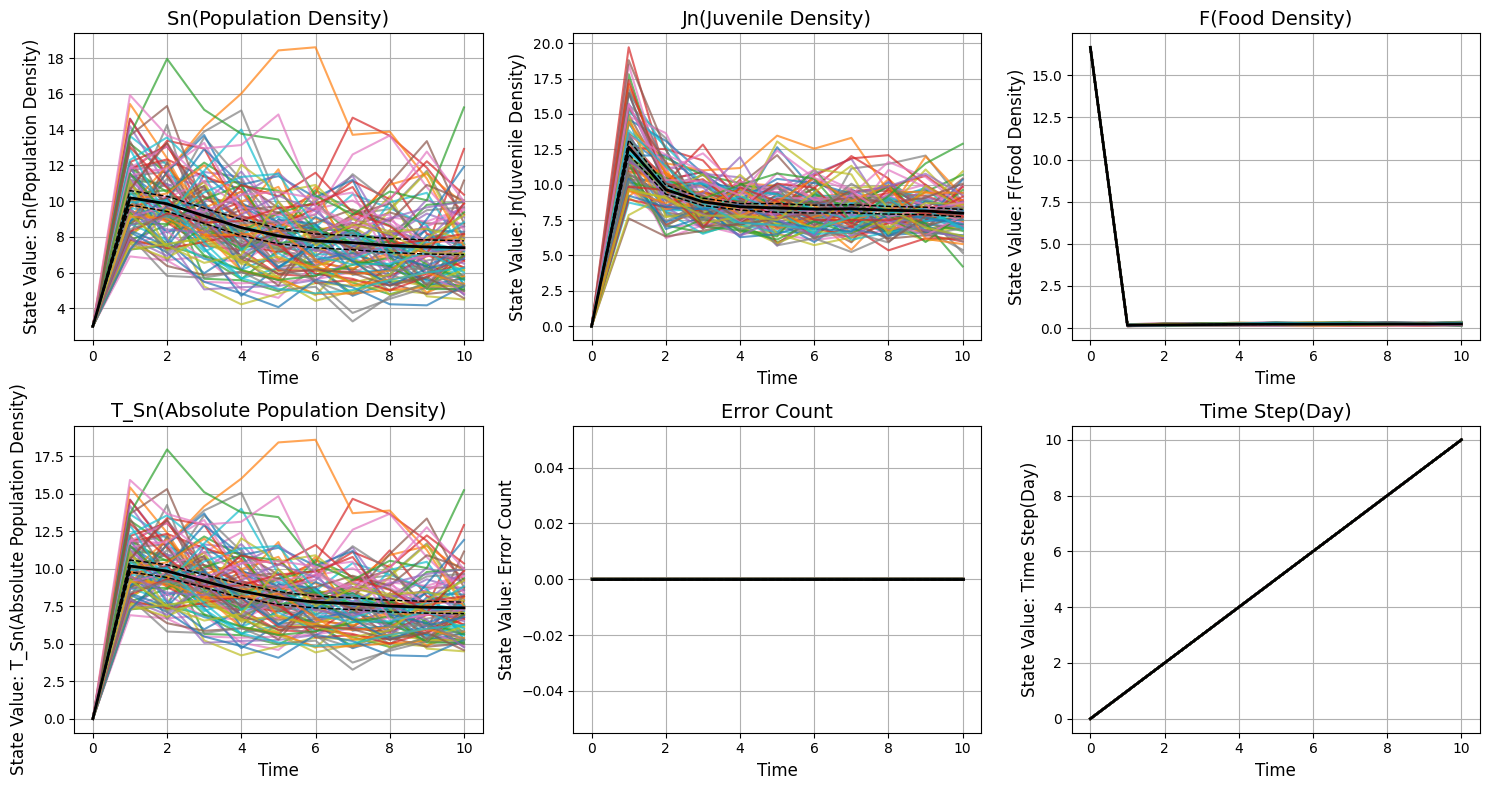

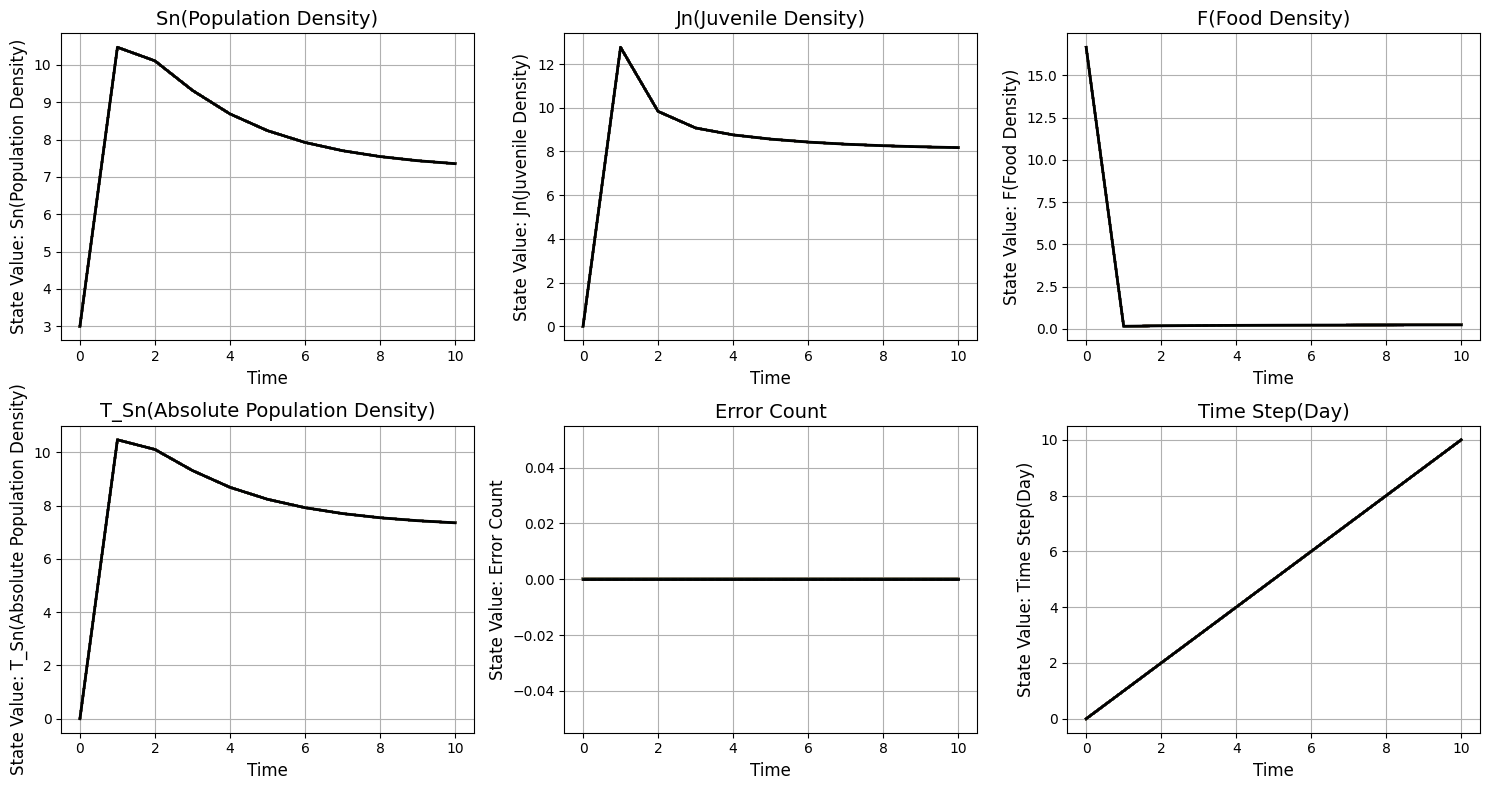

In [144]:
# create the POMP object
dentadult1 = jnp.array(data[0]['dent.adult'].to_numpy())
day1 = jnp.array(data[0]['day'].to_numpy())
covars1 = jnp.diff(day1, prepend=0)
        
thetas = transform_thetas(0.1, 0.1, 0.1, 10, 1, 0.1, 0.1, 0.1, 0.1)
state_names=["Sn(Population Density)", "Jn(Juvenile Density)", "F(Food Density)", 
            "T_Sn(Absolute Population Density)", "Error Count", "Time Step(Day)"]
daph_pomp_obj = Pomp(rinit, rproc, dmeas, ys=dentadult1, theta=thetas, covars=covars1)
state_list_daph_pomp, lower_CI_daph, upper_CI_daph = simulate(daph_pomp_obj, 100, key=jax.random.PRNGKey(2468), state_names=state_names)

daph_pomp_obj_rm = Pomp(rinit, rproc_noi_rm, dmeas, ys=dentadult1, theta=thetas, covars=covars1)
state_list_daph_pomp_rm, lower_CI_daph_rm, upper_CI_daph_rm = simulate(daph_pomp_obj_rm, 100, key=jax.random.PRNGKey(2468), state_names=state_names)



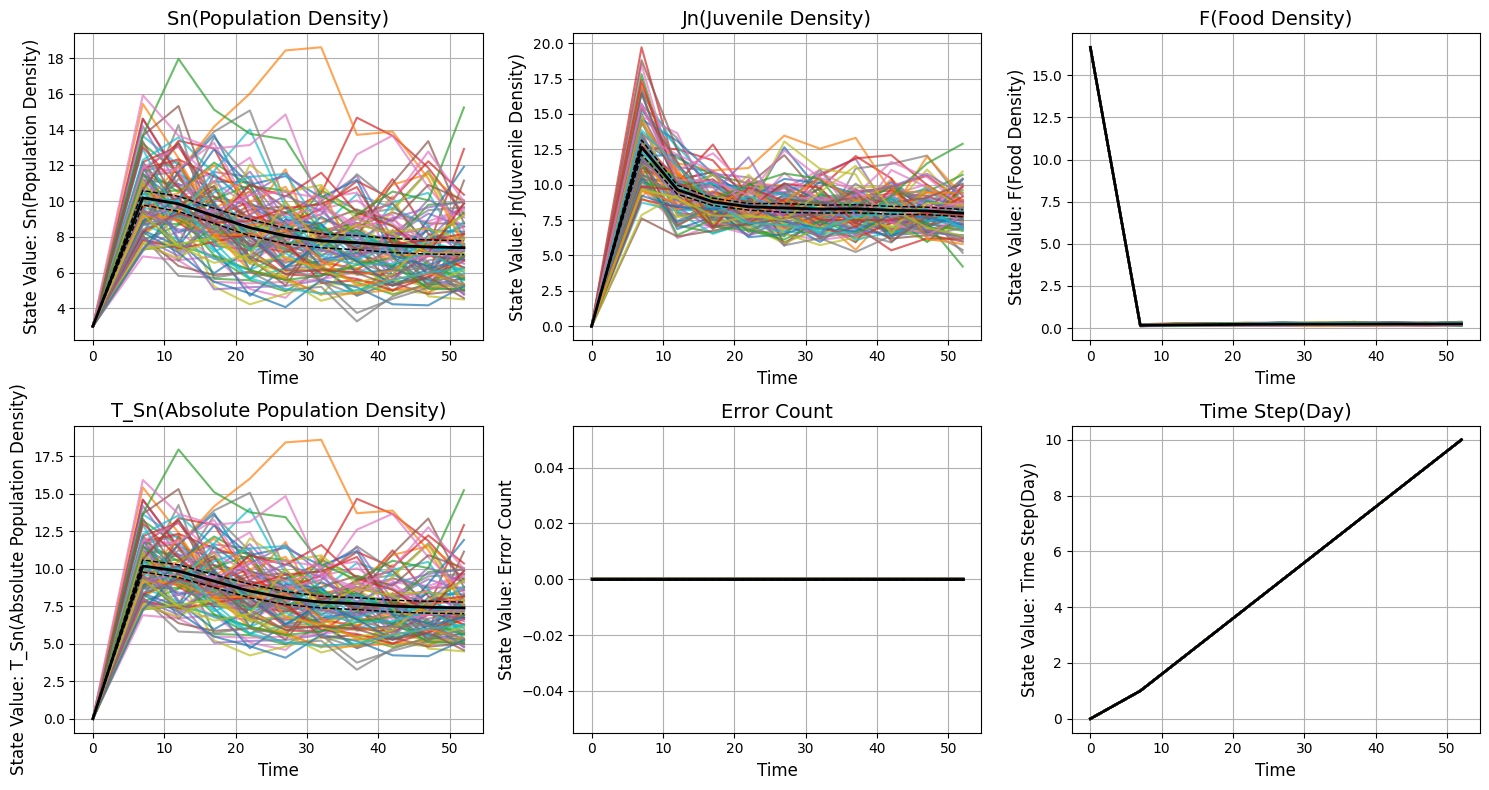

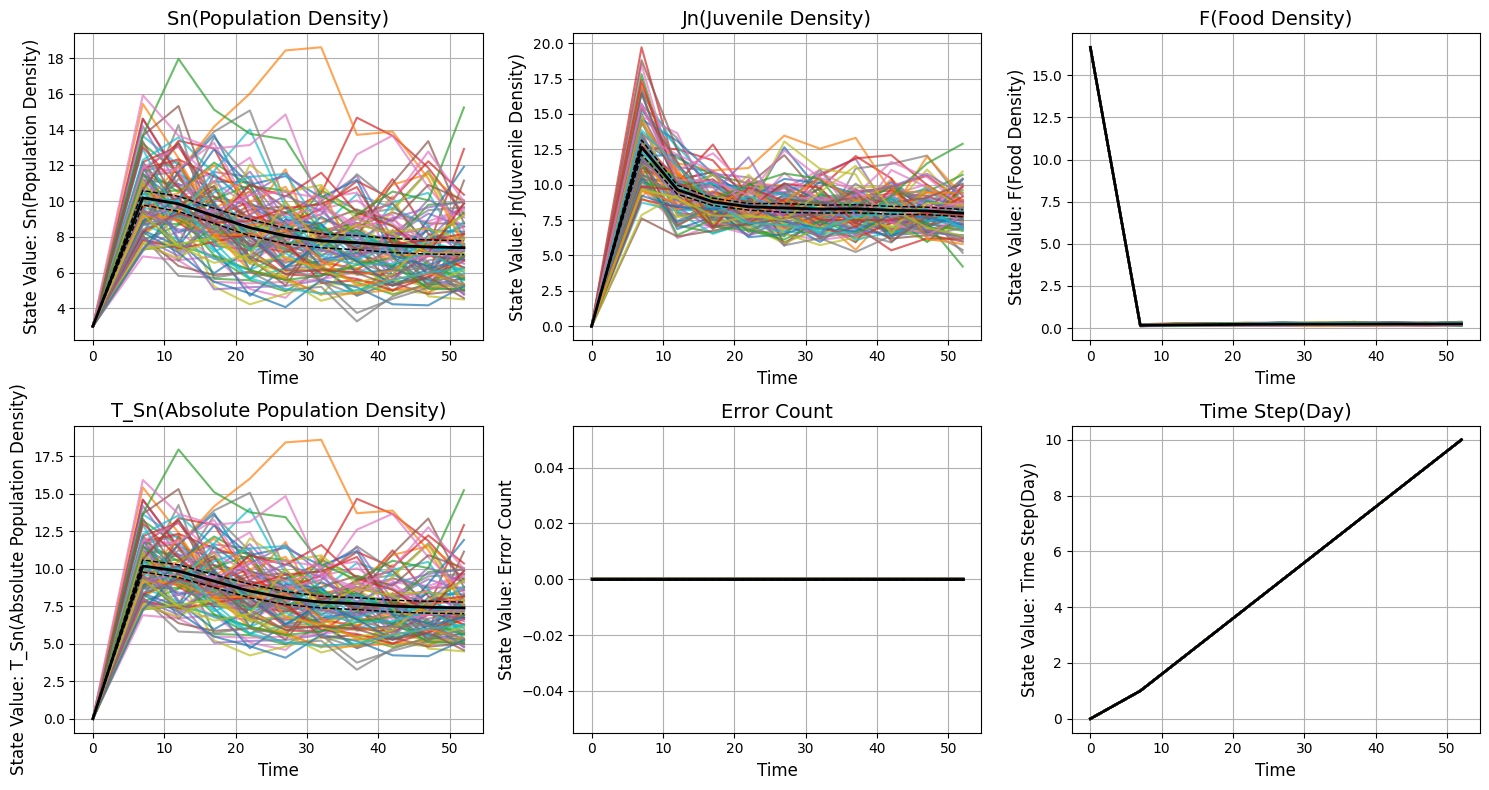

In [145]:
daph_pomp_obj = Pomp(rinit, rproc, dmeas, ys=dentadult1, theta=thetas, covars=covars1)
time = np.array([7, 12, 17, 22, 27, 32, 37, 42, 47, 52])
state_list_daph_pomp_df, lower_CI_daph_df, upper_CI_daph_df = simulate(rinit=rinit, rprocess=rprocess, ys=dentadult1, theta=thetas, covars=covars1, Nsim=100, key=jax.random.PRNGKey(2468), state_names=state_names, format = "data.frame", time_vec=time)

daph_pomp_obj_rm = Pomp(rinit, rproc_noi_rm, dmeas, ys=dentadult1, theta=thetas, covars=covars1)
state_list_daph_pomp_rm_df, lower_CI_daph_rm_df, upper_CI_daph_rm_df = simulate(rinit=rinit, rprocess=rprocess, ys=dentadult1, theta=thetas, Nsim=100, covars=covars1, key=jax.random.PRNGKey(2468), state_names=state_names, format = "data.frame", time_vec=time)


In [146]:
print(state_list_daph_pomp_df)
print(lower_CI_daph_df)
print(upper_CI_daph_df)

      Real Time  Sn(Population Density)  Jn(Juvenile Density)  \
0             0                3.000000              0.000000   
1             0                3.000000              0.000000   
2             0                3.000000              0.000000   
3             0                3.000000              0.000000   
4             0                3.000000              0.000000   
...         ...                     ...                   ...   
1095         52                4.568672              7.977535   
1096         52                9.981933              8.727406   
1097         52                5.273966              6.956463   
1098         52                7.062036              6.381870   
1099         52                6.256720              6.926185   

      F(Food Density)  T_Sn(Absolute Population Density)  Error Count  \
0           16.667000                           0.000000          0.0   
1           16.667000                           0.000000          0.0   


In [147]:
print(state_list_daph_pomp)
print(lower_CI_daph)
print(upper_CI_daph)

[[[ 3.          0.         16.667       0.          0.
    0.        ]
  [ 3.          0.         16.667       0.          0.
    0.        ]
  [ 3.          0.         16.667       0.          0.
    0.        ]
  ...
  [ 3.          0.         16.667       0.          0.
    0.        ]
  [ 3.          0.         16.667       0.          0.
    0.        ]
  [ 3.          0.         16.667       0.          0.
    0.        ]]

 [[11.876384   16.465641    0.13539661 11.876384    0.
    1.        ]
  [ 9.5325775  12.52786     0.18129903  9.5325775   0.
    1.        ]
  [11.164964   13.021873    0.15375939 11.164964    0.
    1.        ]
  ...
  [ 8.418365   13.526221    0.15737781  8.418365    0.
    1.        ]
  [ 9.259305    9.696785    0.19802572  9.259305    0.
    1.        ]
  [ 9.929489   13.841901    0.14878681  9.929489    0.
    1.        ]]

 [[ 8.925023    9.605897    0.20078686  8.925023    0.
    2.        ]
  [11.56289    10.367672    0.18897581 11.56289     0.
    2.

Comparison with the simulate() function in R

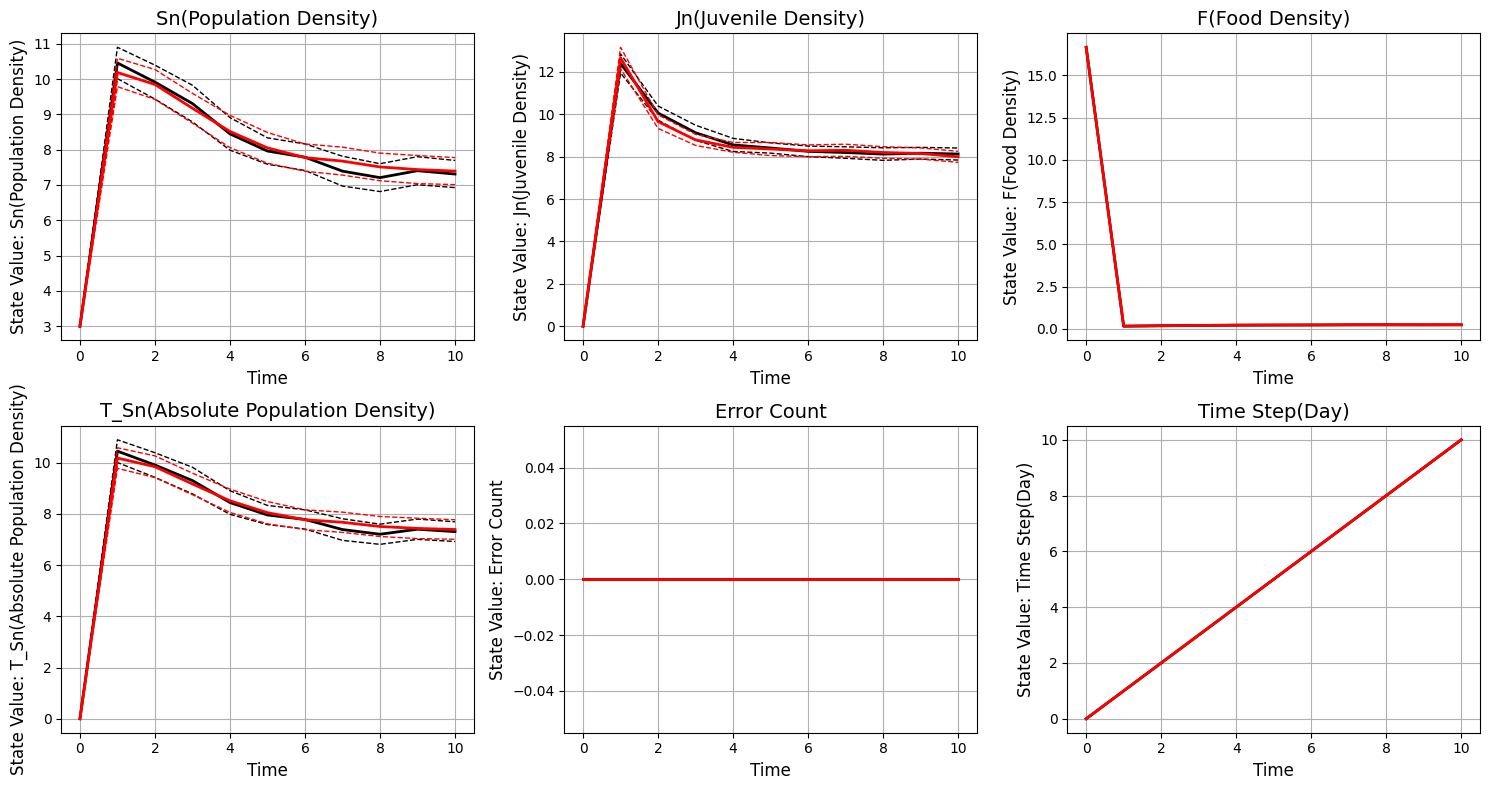

In [148]:
latent_states = state_list_daph_pomp[0].shape[1]

n_cols = 3
n_rows = math.ceil(latent_states / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
axes = axes.flatten()

state_array = np.array(state_list_daph_pomp)  
T_plus_1, J, num_states = state_array.shape

t_critical = stats.t.ppf(0.975, df = J-1)
mean = np.mean(state_array, axis=1)                     
std = np.std(state_array, axis=1, ddof=1)               
margin = t_critical * std / np.sqrt(J)
lower_CI = mean - margin # (T + 1) x num_states
upper_CI = mean + margin


mean_r = np.array([
    [3.000000,  0.000000, 16.6670000,  0.000000, 0, 0],
    [10.453913, 12.391632, 0.1637493, 10.453913, 0, 1],
    [9.912048, 10.053444, 0.1872278, 9.912048, 0, 2],
    [9.304630, 9.123470, 0.2050856, 9.304630, 0, 3],
    [8.446826, 8.550686, 0.2221807, 8.446826, 0, 4],
    [7.960624, 8.405257, 0.2280909, 7.960624, 0, 5],
    [7.785971, 8.247205, 0.2342368, 7.785971, 0, 6],
    [7.391471, 8.191238, 0.2451118, 7.391471, 0, 7],
    [7.207930, 8.118711, 0.2465763, 7.207930, 0, 8],
    [7.404170, 8.160003, 0.2436566, 7.404170, 0, 9],
    [7.309939, 8.120968, 0.2448294, 7.309939, 0, 10]
])

lower_CI_r = np.array([
    [3.000000,  0.000000, 16.6670000,  0.000000, 0, 0],
    [10.009767, 11.941672, 0.1586996, 10.009767, 0, 1],
    [9.431291, 9.719907, 0.1804683, 9.431291, 0, 2],
    [8.785777, 8.767526, 0.1966296, 8.785777, 0, 3],
    [7.986157, 8.241343, 0.2131448, 7.986157, 0, 4],
    [7.587310, 8.163289, 0.2206242, 7.587310, 0, 5],
    [7.410476, 7.998110, 0.2262239, 7.410476, 0, 6],
    [6.969173, 7.920686, 0.2349694, 6.969173, 0, 7],
    [6.813541, 7.823040, 0.2367479, 6.813541, 0, 8],
    [7.007729, 7.884601, 0.2334696, 7.007729, 0, 9],
    [6.925099, 7.837534, 0.2353299, 6.925099, 0, 10]
])

upper_CI_r = np.array([
    [3.000000,  0.000000, 16.6670000,  0.000000, 0, 0],
    [10.898059, 12.841592, 0.1687990, 10.898059, 0, 1],
    [10.392804, 10.386981, 0.1939873, 10.392804, 0, 2],
    [9.823483, 9.479415, 0.2135417, 9.823483, 0, 3],
    [8.907494, 8.860029, 0.2312167, 8.907494, 0, 4],
    [8.333938, 8.647225, 0.2355577, 8.333938, 0, 5],
    [8.161466, 8.496300, 0.2422496, 8.161466, 0, 6],
    [7.813769, 8.461791, 0.2552541, 7.813769, 0, 7],
    [7.602320, 8.414382, 0.2564048, 7.602320, 0, 8],
    [7.800610, 8.435404, 0.2538436, 7.800610, 0, 9],
    [7.694779, 8.404402, 0.2543290, 7.694779, 0, 10]
])

for state in range(latent_states):
    #ax = axes[state // 3, state % 3]  
    ax = axes[state]
    time = np.arange(0, 11)
    
    ax.plot(time, mean_r[:, state], color='black', linewidth=2, label='Mean')
    ax.plot(time, upper_CI_r[:, state], color='black', linestyle='--', linewidth=1, label='Upper')
    ax.plot(time, lower_CI_r[:, state], color='black', linestyle='--', linewidth=1, label='Lower')
    ax.plot(time, mean[:, state], color='red', linewidth=2, label='Mean')
    ax.plot(time, upper_CI[:, state], color='red', linestyle='--', linewidth=1, label='Upper')
    ax.plot(time, lower_CI[:, state], color='red', linestyle='--', linewidth=1, label='Lower')
    ax.set_title(state_names[state], fontsize=14)
    ax.set_xlabel("Time", fontsize=12)
    ax.set_ylabel(f"State Value: {state_names[state]}", fontsize=12)
    ax.grid(True)

for i in range(latent_states, len(axes)):
    fig.delaxes(axes[i])
    
plt.tight_layout()
plt.show()

LG:

In [150]:
LG_obj, ys_LG, theta_LG, covars_LG, rinit_LG, rproc_LG, dmeas_LG, rprocess_LG, dmeasure_LG, rprocesses_LG, dmeasures_LG = LG_internal(T=10) 


100%|██████████| 10/10 [00:00<00:00, 855.51it/s]


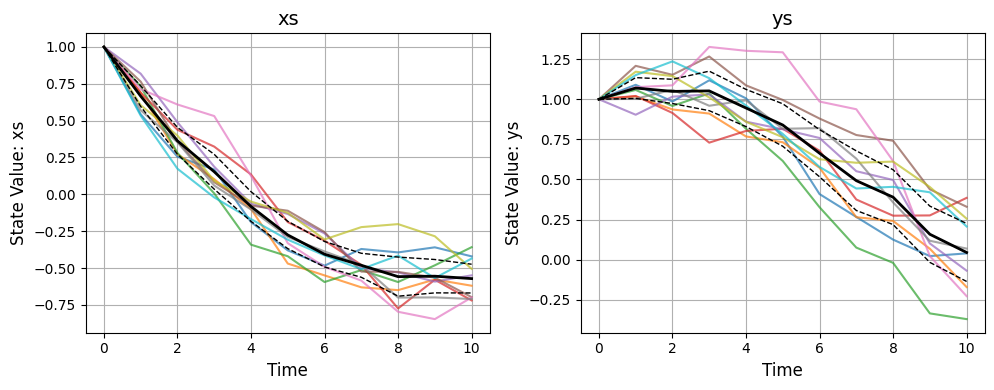

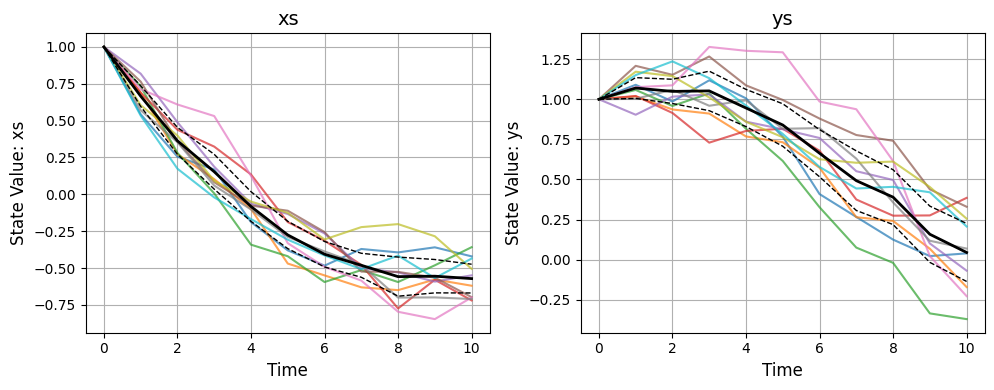

In [151]:
state_names_LG = ['xs','ys']
state_list_LG_pomp_df, lower_CI_LG_df, upper_CI_LG_df = simulate(LG_obj, Nsim=10, key=jax.random.PRNGKey(2468), state_names=state_names_LG, format="data.frame")
state_list_LG_pomp, lower_CI_LG, upper_CI_LG = simulate(rinit=rinit_LG, rprocess=rprocess_LG, ys=ys_LG, theta=theta_LG, covars=covars_LG, Nsim=10, key=jax.random.PRNGKey(2468), state_names=state_names_LG)

In [152]:
print(state_list_LG_pomp_df)
print(lower_CI_LG_df)
print(upper_CI_LG_df)

     Real Time        xs        ys
0            0  1.000000  1.000000
1            0  1.000000  1.000000
2            0  1.000000  1.000000
3            0  1.000000  1.000000
4            0  1.000000  1.000000
..         ...       ...       ...
105         10 -0.697599  0.329675
106         10 -0.699755 -0.227855
107         10 -0.710426  0.068790
108         10 -0.505573  0.255471
109         10 -0.435744  0.206565

[110 rows x 3 columns]
    Real Time        xs        ys
0           0  1.000000  1.000000
1           1  0.596079  1.005211
2           2  0.271761  0.973632
3           3  0.035046  0.928922
4           4 -0.183631  0.829691
5           5 -0.368493  0.707135
6           6 -0.492888  0.516693
7           7 -0.562918  0.306477
8           8 -0.691289  0.218588
9           9 -0.668807 -0.017366
10         10 -0.669412 -0.136280
    Real Time        xs        ys
0           0  1.000000  1.000000
1           1  0.596079  1.005211
2           2  0.271761  0.973632
3           

In [153]:
def get_thetas(theta):
    A = theta[0:4].reshape(2, 2)
    C = theta[4:8].reshape(2, 2)
    Q = theta[8:12].reshape(2, 2)
    R = theta[12:16].reshape(2, 2)
    return A, C, Q, R

# remove the randomness
def rproc_LG_rm(state, theta, key, covars=None):
    A, C, Q, R = get_thetas(theta)
    key, subkey = jax.random.split(key)
    return A@state

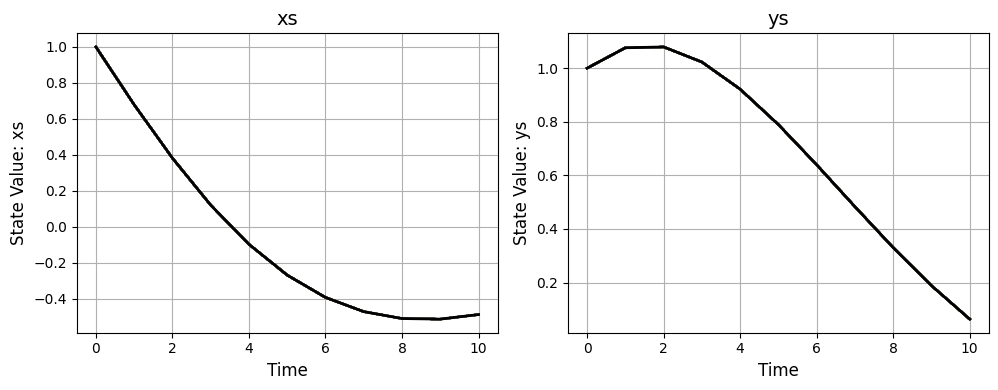

(array([[[ 1.        ,  1.        ],
        [ 1.        ,  1.        ],
        [ 1.        ,  1.        ],
        ...,
        [ 1.        ,  1.        ],
        [ 1.        ,  1.        ],
        [ 1.        ,  1.        ]],

       [[ 0.67891324,  1.0762519 ],
        [ 0.67891324,  1.0762519 ],
        [ 0.67891324,  1.0762519 ],
        ...,
        [ 0.67891324,  1.0762519 ],
        [ 0.67891324,  1.0762519 ],
        [ 0.67891324,  1.0762519 ]],

       [[ 0.3819842 ,  1.0793791 ],
        [ 0.3819842 ,  1.0793791 ],
        [ 0.3819842 ,  1.0793791 ],
        ...,
        [ 0.3819842 ,  1.0793791 ],
        [ 0.3819842 ,  1.0793791 ],
        [ 0.3819842 ,  1.0793791 ]],

       ...,

       [[-0.5098696 ,  0.33053097],
        [-0.5098696 ,  0.33053097],
        [-0.5098696 ,  0.33053097],
        ...,
        [-0.5098696 ,  0.33053097],
        [-0.5098696 ,  0.33053097],
        [-0.5098696 ,  0.33053097]],

       [[-0.513119  ,  0.18877277],
        [-0.513119  ,  0.1

In [154]:
LG_rm_obj = Pomp(rinit_LG, rproc_LG_rm, dmeas_LG, ys=ys_LG, theta=theta_LG, covars=covars_LG)
state_list_LG_pomp_rm = simulate(LG_rm_obj, len(ys_LG), key=jax.random.PRNGKey(2468), state_names=state_names_LG)
print(state_list_LG_pomp_rm)

Try Dacca

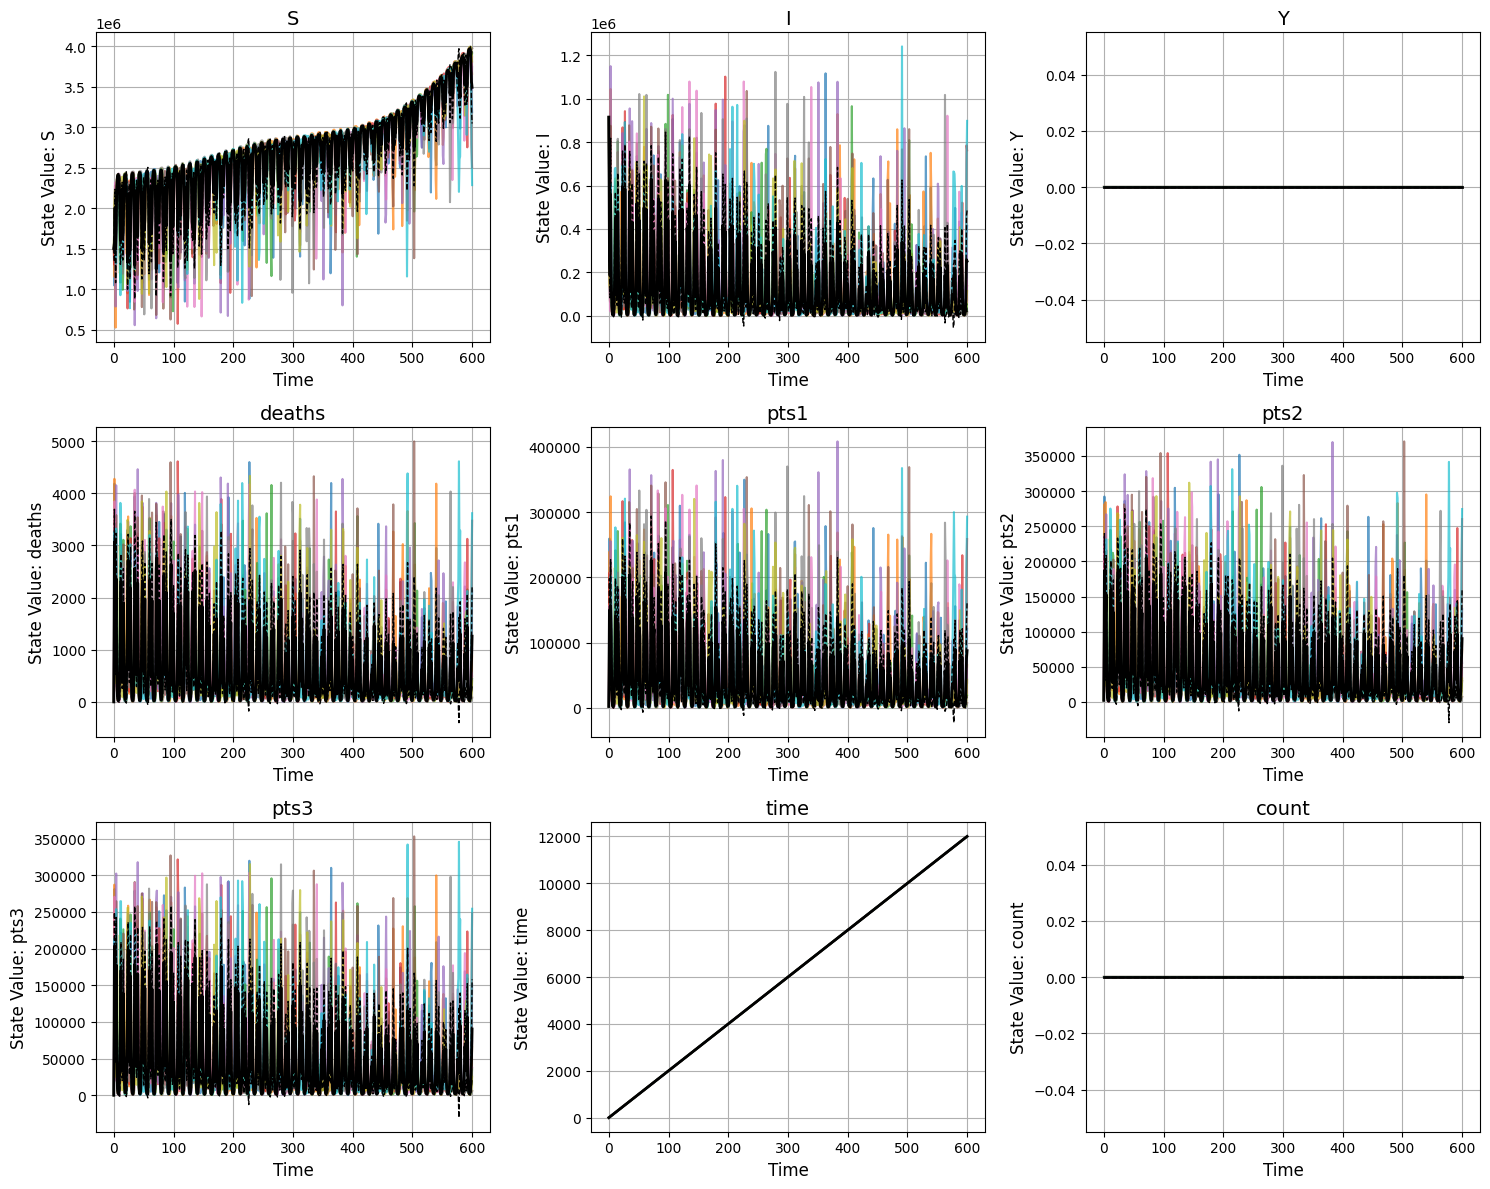

In [138]:
dacca_obj, ys_dacca, theta_dacca, covars_dacca, rinit_dacca, rproc_dacca, dmeas_dacca, rprocess_dacca, dmeasure_dacca, rprocesses_dacca, dmeasures_dacca = dacca_internal() 
state_names_dacca = ["S", "I", "Y", "deaths", "pts1", "pts2", "pts3", "time", "count"]
state_list_dacca_pomp = simulate(dacca_obj, len(ys_dacca), Nsim=10, key=jax.random.PRNGKey(2468), state_names=state_names_dacca)

In [139]:
def sigmoid(x):
    return 1/(1+jnp.exp(-x))

def get_thetas_dacca(theta):
    gamma = jnp.exp(theta[0])
    m = jnp.exp(theta[1]) 
    rho = jnp.exp(theta[2]) 
    epsilon = jnp.exp(theta[3]) 
    omega = jnp.exp(theta[4])
    c = sigmoid(theta[5] ) 
    beta_trend = theta[6] / 100 
    sigma = jnp.exp(theta[7])
    tau = jnp.exp(theta[8]) 
    bs = theta[9:15] 
    omegas = theta[15:]
    k = 3 
    delta = 0.02 
    return gamma, m, rho, epsilon, omega, c, beta_trend, sigma, tau, bs, omegas, k, delta


def rproc_dacca_rm(state, theta, key, covars):
    S, I, Y, deaths, pts, t, count = state[0], state[1], state[2], state[3], state[4:-2], state[-2], state[-1]
    t = t.astype(int)
    trends, dpopdts, pops, seass = covars[:,0], covars[:,1], covars[:,2], covars[:,3:]
    gamma, deltaI, rho, eps, omega, clin, beta_trend, sd_beta, tau, bs, omegas, nrstage, delta = get_thetas_dacca(theta)
    dt = 1/240
    deaths = 0
    nrstage = 3
    clin = 1 # HARDCODED SEIR
    rho = 0 # HARDCODED INAPPARENT INFECTIONS
    std = jnp.sqrt(dt) #onp.sqrt(onp.sqrt(dt))
    
    neps = eps*nrstage #rate
    rdeaths = jnp.zeros(nrstage) #the number of death in R1, R2, R3
    passages = jnp.zeros(nrstage+1)
    
    for i in range(20):
        trend = trends[t]; dpopdt = dpopdts[t]; pop = pops[t]; seas = seass[t]
        beta = jnp.exp(beta_trend*trend + jnp.dot(bs, seas))
        omega = jnp.exp(jnp.dot(omegas, seas))
        
        subkey, key = jax.random.split(key) 
        #dw = jax.random.normal(subkey)*std 
        dw = std
        
        effI = I/pop
        births = dpopdt + delta*pop # births
        passages = passages.at[0].set(gamma*I) # recovery
        ideaths = delta*I # natural i deaths
        disease = deltaI*I # disease death
        ydeaths = delta*Y # natural rs deaths
        wanings = rho*Y # loss of immunity
        
        for j in range(nrstage):
            rdeaths = rdeaths.at[j].set(pts[j]*delta) # natural R deaths
            passages = passages.at[j+1].set(pts[j]*neps) # passage to the next immunity class
            
        infections = (omega+(beta+sd_beta*dw/dt)*effI)*S # infection 
        sdeaths = delta*S # natural S deaths
        
        S += (births - infections - sdeaths + passages[nrstage] + wanings)*dt 
        I += (clin*infections - disease - ideaths - passages[0])*dt
        Y += ((1-clin)*infections - ydeaths - wanings)*dt

        for j in range(nrstage):
            pts = pts.at[j].add((passages[j] - passages[j+1] - rdeaths[j])*dt)
        deaths += disease*dt # cumulative deaths from disease
                        
        count += jnp.any(jnp.hstack([jnp.array([S, I, Y, deaths]), pts]) < 0)
        
        S = jnp.clip(S, min=0); I = jnp.clip(I, min=0); Y = jnp.clip(Y, min=0)
        pts = jnp.clip(pts, min=0); deaths = jnp.clip(deaths, min=0)
        
        t += 1

    return jnp.hstack([jnp.array([S, I, Y, deaths]), pts, jnp.array([t]), jnp.array([count])])


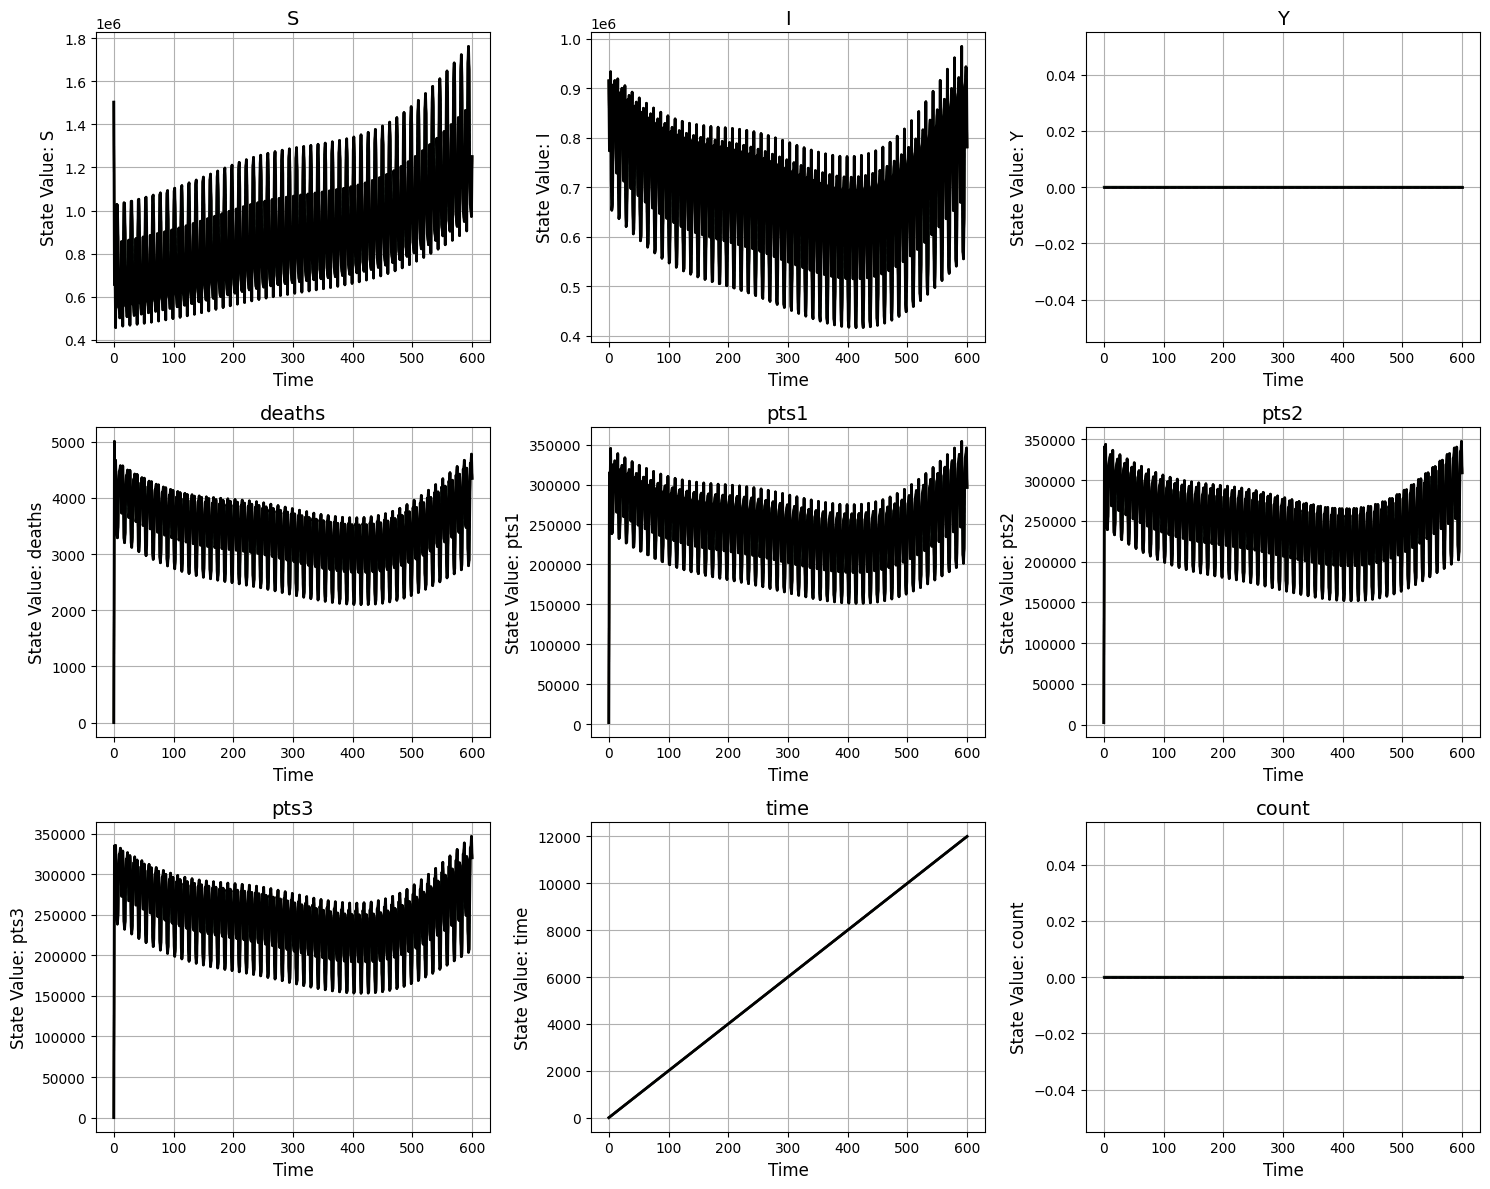

In [140]:
dacca_rm_obj = Pomp(rinit_dacca, rproc_dacca_rm, dmeas_dacca, ys=ys_dacca, theta=theta_dacca, covars=covars_dacca)
state_list_dacca_pomp_rm = simulate(dacca_rm_obj, len(ys_dacca), Nsim=10, key=jax.random.PRNGKey(2468), state_names=state_names_dacca)